In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession

sc= SparkSession.builder.appName("Marver_Network").getOrCreate()

bookdf = sc.read.option("header","true").option("inferSchema","true").text("Books.txt")
characterdf = sc.read.option("header","true").option("inferSchema","true").text("Characters.txt")
edgesdf = sc.read.option("header","true").option("inferSchema","true").text("Edges.txt")

In [3]:
bookdf.take(10)

[Row(value='Vertex 6487: AA2 35'),
 Row(value='Vertex 6488: M/PRM 35'),
 Row(value='Vertex 6489: M/PRM 36'),
 Row(value='Vertex 6490: M/PRM 37'),
 Row(value='Vertex 6491: WI? 9'),
 Row(value='Vertex 6492: AVF 4'),
 Row(value='Vertex 6493: AVF 5'),
 Row(value='Vertex 6494: H2 251'),
 Row(value='Vertex 6495: H2 252'),
 Row(value='Vertex 6496: COC 1')]

In [4]:
characterdf.take(10)

[Row(value='Vertex 1: 24-HOUR MAN/EMMANUEL'),
 Row(value='Vertex 2: 3-D MAN/CHARLES CHANDLER & HAROLD CHANDLER'),
 Row(value='Vertex 3: 4-D MAN/MERCURIO'),
 Row(value='Vertex 4: 8-BALL/'),
 Row(value='Vertex 5: A'),
 Row(value="Vertex 6: A'YIN"),
 Row(value='Vertex 7: ABBOTT, JACK'),
 Row(value='Vertex 8: ABCISSA'),
 Row(value='Vertex 9: ABEL'),
 Row(value='Vertex 10: ABOMINATION/EMIL BLONSKY')]

In [5]:
edgesdf.take(15)

[Row(value='*Vertices 19428 6486'),
 Row(value='1 "24-HOUR MAN/EMMANUEL"'),
 Row(value='2 "3-D MAN/CHARLES CHAN"'),
 Row(value='3 "4-D MAN/MERCURIO"'),
 Row(value='4 "8-BALL/"'),
 Row(value='5 "A"'),
 Row(value='6 "A\'YIN"'),
 Row(value='7 "ABBOTT, JACK"'),
 Row(value='8 "ABCISSA"'),
 Row(value='9 "ABEL"'),
 Row(value='10 "ABOMINATION/EMIL BLO"'),
 Row(value='11 "ABOMINATION | MUTANT"'),
 Row(value='12 "ABOMINATRIX"'),
 Row(value='13 "ABRAXAS"'),
 Row(value='14 "ADAM 3,031"')]

**Cleaning and Transforming Edges.txt file**

In [6]:
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

def edgeFilter(row):
    if ('*' in row) or ('"' in row):
        return False
    else:
        return True

udf_edgeFilter = udf(edgeFilter, BooleanType())

edge_cleaned = edgesdf.filter(udf_edgeFilter(edgesdf["value"]))

In [7]:
edge_cleaned.take(10)

[Row(value='1 6487'),
 Row(value='2 6488 6489 6490 6491 6492 6493 6494 6495 6496'),
 Row(value='3 6497 6498 6499 6500 6501 6502 6503 6504 6505'),
 Row(value='4 6506 6507 6508'),
 Row(value='5 6509 6510 6511'),
 Row(value='6 6512 6513 6514 6515'),
 Row(value='7 6516'),
 Row(value='8 6517 6518'),
 Row(value='9 6519 6520'),
 Row(value='10 6521 6522 6523 6524 6525 6526 6527 6528 6529 6530 6531 6532 6533 6534 6535')]

**Coverting string rows into key value pair using Df to RDD and vice-versa conversion**

In [14]:
edge_maped_charactr = edge_cleaned.rdd.map(lambda x:x[0].split(" ")).map(lambda x : (x[0], x[1:]) )

# here x[0] is bit tricky, if not used it will throw an error when calling collect on the rdd
# as we did not specify which  column to split

In [9]:
edge_maped_charactr

PythonRDD[23] at RDD at PythonRDD.scala:53

In [11]:
edgeColumns = ["character_name","books_appeared_in"]
edge_map_ctr_df=edge_maped_charactr.toDF(edgeColumns)

In [12]:
edge_map_ctr_df.printSchema()

root
 |-- character_name: string (nullable = true)
 |-- books_appeared_in: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [13]:
edge_map_ctr_df.take(10)

[Row(character_name='1', books_appeared_in=['6487']),
 Row(character_name='2', books_appeared_in=['6488', '6489', '6490', '6491', '6492', '6493', '6494', '6495', '6496']),
 Row(character_name='3', books_appeared_in=['6497', '6498', '6499', '6500', '6501', '6502', '6503', '6504', '6505']),
 Row(character_name='4', books_appeared_in=['6506', '6507', '6508']),
 Row(character_name='5', books_appeared_in=['6509', '6510', '6511']),
 Row(character_name='6', books_appeared_in=['6512', '6513', '6514', '6515']),
 Row(character_name='7', books_appeared_in=['6516']),
 Row(character_name='8', books_appeared_in=['6517', '6518']),
 Row(character_name='9', books_appeared_in=['6519', '6520']),
 Row(character_name='10', books_appeared_in=['6521', '6522', '6523', '6524', '6525', '6526', '6527', '6528', '6529', '6530', '6531', '6532', '6533', '6534', '6535'])]

In [18]:
edge_map_ctr_df.write.format("json").save("Edge_Transform.json")


**Cleaning and Transforming Characters.txt file**

In [20]:
characterdf.printSchema()

root
 |-- value: string (nullable = true)



In [29]:
characterdf.take(3)

[Row(value='Vertex 1: 24-HOUR MAN/EMMANUEL'),
 Row(value='Vertex 2: 3-D MAN/CHARLES CHANDLER & HAROLD CHANDLER'),
 Row(value='Vertex 3: 4-D MAN/MERCURIO')]

In [32]:
def characterParse(row):
    row = row[0].split(":")
    return ( row[0][7:], row[1].strip() )

char_transform = characterdf.rdd.map(characterParse).collectAsMap()

In [34]:
len(char_transform)

6486

 **Now to count the number of appearance of each character in the books, we need to group by key and count the length of column 2 (the book numbers in which the char appears)**

In [43]:
#first count the appearance for each key which has maximum of 15 records 
#second map charactername with the length or count
#third groupby /reducebyKey

charstrength = edge_maped_charactr.mapValues(lambda x: len(x)).map(lambda x : (char_transform[x[0]],x[1])).reduceByKey(lambda x,y:x+y).sortBy(lambda x:-x[1])




In [45]:
charstrength.take(10)

[('SPIDER-MAN/PETER PARKER', 1625),
 ('CAPTAIN AMERICA', 1367),
 ('IRON MAN/TONY STARK', 1168),
 ('THING/BENJAMIN J. GRIMM', 990),
 ('THOR/DR. DONALD BLAKE/SIGURD JARLSON II/JAKE OLSON/LOREN OLSON', 965),
 ('HUMAN TORCH/JOHNNY STORM', 908),
 ('MR. FANTASTIC/REED RICHARDS', 875),
 ('HULK/DR. ROBERT BRUCE BANNER', 841),
 ('WOLVERINE/LOGAN', 820),
 ('INVISIBLE WOMAN/SUE STORM RICHARDS', 782)]

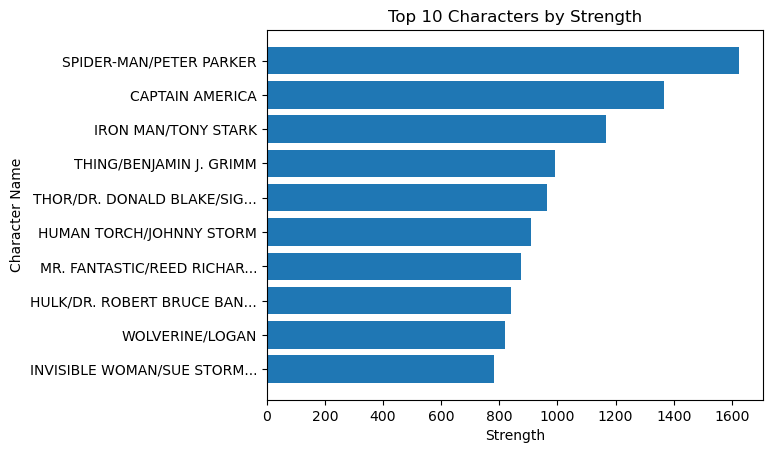

In [69]:
import matplotlib.pyplot as plt

# Get the top 10 characters by strength
top_chars = charstrength.takeOrdered(10, key=lambda x: -x[1])

# Extract the names and values
names = [c[0] if len(c[0])<25 else (c[0][:25]+"...") for c in top_chars]
values = [c[1] for c in top_chars]

# Plot the histogram horizontally
plt.barh(names, values)
plt.xlabel("Strength")
plt.ylabel("Character Name")
plt.title("Top 10 Characters by Strength")

# Invert the y-axis to show names from top to bottom
plt.gca().invert_yaxis()

plt.show()






